# Santander Customer Transaction Prediction - XGBoost

In the Kaggle competition, the objective is to identify which customer will make a transaction in the future.

**Link to the competition**: https://www.kaggle.com/c/santander-customer-transaction-prediction/  
**Type of Problem**: Classification  
**Metric for evalution**: AOC (Area Under Curve)

This Python 3 environment comes with many helpful analytics libraries installed
It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

In [1]:
import numpy as np
import pandas as pd

import xgboost
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/santander-customer-transaction-prediction/sample_submission.csv
/kaggle/input/santander-customer-transaction-prediction/train.csv
/kaggle/input/santander-customer-transaction-prediction/test.csv
/kaggle/input/cv-results/cv_results_fin.csv


### 1. Read Train CSV

In [3]:
input_dir = '/kaggle/input/santander-customer-transaction-prediction/'
df_train = pd.read_csv(input_dir + '/train.csv')
df_train

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,train_199995,0,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,...,6.1415,13.2305,3.9901,0.9388,18.0249,-1.7939,2.1661,8.5326,16.6660,-17.8661
199996,train_199996,0,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,...,4.9611,4.6549,0.6998,1.8341,22.2717,1.7337,-2.1651,6.7419,15.9054,0.3388
199997,train_199997,0,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,...,4.0651,5.4414,3.1032,4.8793,23.5311,-1.5736,1.2832,8.7155,13.8329,4.1995
199998,train_199998,0,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,...,2.6840,8.6587,2.7337,11.1178,20.4158,-0.0786,6.7980,10.0342,15.5289,-13.9001


In [4]:
var_colums = [c for c in df_train.columns if c not in ['ID_code','target']]
X = df_train.loc[:, var_colums]
y = df_train.loc[:, 'target']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((160000, 200), (40000, 200), (160000,), (40000,))

### 2. Create XGBoost Model

In [5]:
xgboost.XGBClassifier().get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': None,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [6]:
model_xgboost = xgboost.XGBClassifier(learning_rate=0.1,
                                      max_depth=5,
                                      n_estimators=5000,
                                      subsample=0.5,
                                      colsample_bytree=0.5,
                                      eval_metric='auc',
                                      verbosity=1)

eval_set = [(X_valid, y_valid)]

model_xgboost.fit(X_train,
                  y_train,
                  early_stopping_rounds=10,
                  eval_set=eval_set,
                  verbose=True)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.61063
[1]	validation_0-auc:0.64763
[2]	validation_0-auc:0.67923
[3]	validation_0-auc:0.69883
[4]	validation_0-auc:0.70108
[5]	validation_0-auc:0.71442
[6]	validation_0-auc:0.72371
[7]	validation_0-auc:0.72779
[8]	validation_0-auc:0.73284
[9]	validation_0-auc:0.73574
[10]	validation_0-auc:0.73761
[11]	validation_0-auc:0.74516
[12]	validation_0-auc:0.75023
[13]	validation_0-auc:0.75050
[14]	validation_0-auc:0.74988
[15]	validation_0-auc:0.75296
[16]	validation_0-auc:0.75487
[17]	validation_0-auc:0.75969
[18]	validation_0-auc:0.76267
[19]	validation_0-auc:0.76374
[20]	validation_0-auc:0.76787
[21]	validation_0-auc:0.76889
[22]	validation_0-auc:0.77059
[23]	validation_0-auc:0.77510
[24]	validation_0-auc:0.77709
[25]	validation_0-auc:0.77839
[26]	validation_0-auc:0.77742
[27]	validation_0-auc:0.78016
[28]	validation_0-auc:0.78302
[29]	validation_0-auc:0.78538
[30]	validation_0-auc:0.78847
[31]	validation_0-auc:0.78964
[32]	validation_0-auc:0.79178
[33]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=5000, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.5, tree_method='exact',
              validate_parameters=1, verbosity=1)

### 3.Evaluate Model Performance

In [7]:
y_train_pred = model_xgboost.predict_proba(X_train)[:,1]
y_valid_pred = model_xgboost.predict_proba(X_valid)[:,1]

print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                    roc_auc_score(y_valid, y_valid_pred)))

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


AUC Train: 0.9682
AUC Valid: 0.8827


### 4. Hyperparameter Tuning
We will use `GridSearchCV` for hyperparameter tuning. As the first step, let us define all the possible hyperparameter values which we want to check.

In [8]:
learning_rate_list = [0.02, 0.05, 0.1]
max_depth_list = [2, 3, 5]
n_estimators_list = [1000, 2000, 3000]

params_dict = {"learning_rate": learning_rate_list,
               "max_depth": max_depth_list,
               "n_estimators": n_estimators_list}

num_combinations = 1
for v in params_dict.values(): num_combinations *= len(v) 

print(num_combinations)
params_dict

27


{'learning_rate': [0.02, 0.05, 0.1],
 'max_depth': [2, 3, 5],
 'n_estimators': [1000, 2000, 3000]}

Now let us pass this to `GridSearchCV`. We have a custom scoring function based on sklearn's `roc_auc_score()` which calculated area under the curve. CV value is 2, which is not ideal but we want to minimize the execution time.

In [9]:
def my_roc_auc_score(model, X, y): return roc_auc_score(y, model.predict_proba(X)[:,1])

model_xgboost_hp = GridSearchCV(estimator=xgboost.XGBClassifier(subsample=0.5,
                                                                colsample_bytree=0.25,
                                                                eval_metric='auc',
                                                                use_label_encoder=False),
                                param_grid=params_dict,
                                cv=2,
                                scoring=my_roc_auc_score,
                                return_train_score=True,
                                verbose=4)

model_xgboost_hp.fit(X, y)

Fitting 2 folds for each of 27 candidates, totalling 54 fits


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 1/2] END learning_rate=0.02, max_depth=2, n_estimators=1000; total time= 2.5min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 2/2] END learning_rate=0.02, max_depth=2, n_estimators=1000; total time= 2.6min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 1/2] END learning_rate=0.02, max_depth=2, n_estimators=2000; total time= 5.0min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 2/2] END learning_rate=0.02, max_depth=2, n_estimators=2000; total time= 5.0min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 1/2] END learning_rate=0.02, max_depth=2, n_estimators=3000; total time= 7.6min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 2/2] END learning_rate=0.02, max_depth=2, n_estimators=3000; total time= 7.5min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 1/2] END learning_rate=0.02, max_depth=3, n_estimators=1000; total time= 3.6min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 2/2] END learning_rate=0.02, max_depth=3, n_estimators=1000; total time= 3.6min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 1/2] END learning_rate=0.02, max_depth=3, n_estimators=2000; total time= 7.2min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 2/2] END learning_rate=0.02, max_depth=3, n_estimators=2000; total time= 7.2min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 1/2] END learning_rate=0.02, max_depth=3, n_estimators=3000; total time=10.8min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 2/2] END learning_rate=0.02, max_depth=3, n_estimators=3000; total time=10.7min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 1/2] END learning_rate=0.02, max_depth=5, n_estimators=1000; total time= 5.9min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 2/2] END learning_rate=0.02, max_depth=5, n_estimators=1000; total time= 5.9min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 1/2] END learning_rate=0.02, max_depth=5, n_estimators=2000; total time=12.0min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 2/2] END learning_rate=0.02, max_depth=5, n_estimators=2000; total time=11.9min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 1/2] END learning_rate=0.02, max_depth=5, n_estimators=3000; total time=17.9min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 2/2] END learning_rate=0.02, max_depth=5, n_estimators=3000; total time=17.4min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 1/2] END learning_rate=0.05, max_depth=2, n_estimators=1000; total time= 2.4min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 2/2] END learning_rate=0.05, max_depth=2, n_estimators=1000; total time= 2.4min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 1/2] END learning_rate=0.05, max_depth=2, n_estimators=2000; total time= 4.8min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 2/2] END learning_rate=0.05, max_depth=2, n_estimators=2000; total time= 4.8min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 1/2] END learning_rate=0.05, max_depth=2, n_estimators=3000; total time= 7.1min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 2/2] END learning_rate=0.05, max_depth=2, n_estimators=3000; total time= 7.1min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 1/2] END learning_rate=0.05, max_depth=3, n_estimators=1000; total time= 3.4min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 2/2] END learning_rate=0.05, max_depth=3, n_estimators=1000; total time= 3.4min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 1/2] END learning_rate=0.05, max_depth=3, n_estimators=2000; total time= 6.7min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 2/2] END learning_rate=0.05, max_depth=3, n_estimators=2000; total time= 6.7min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 1/2] END learning_rate=0.05, max_depth=3, n_estimators=3000; total time=10.0min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 2/2] END learning_rate=0.05, max_depth=3, n_estimators=3000; total time=10.2min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 1/2] END learning_rate=0.05, max_depth=5, n_estimators=1000; total time= 5.5min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 2/2] END learning_rate=0.05, max_depth=5, n_estimators=1000; total time= 5.5min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 1/2] END learning_rate=0.05, max_depth=5, n_estimators=2000; total time=11.0min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 2/2] END learning_rate=0.05, max_depth=5, n_estimators=2000; total time=11.0min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 1/2] END learning_rate=0.05, max_depth=5, n_estimators=3000; total time=16.5min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 2/2] END learning_rate=0.05, max_depth=5, n_estimators=3000; total time=16.4min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 1/2] END learning_rate=0.1, max_depth=2, n_estimators=1000; total time= 2.4min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 2/2] END learning_rate=0.1, max_depth=2, n_estimators=1000; total time= 2.4min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 1/2] END learning_rate=0.1, max_depth=2, n_estimators=2000; total time= 4.7min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 2/2] END learning_rate=0.1, max_depth=2, n_estimators=2000; total time= 4.7min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 1/2] END learning_rate=0.1, max_depth=2, n_estimators=3000; total time= 7.1min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 2/2] END learning_rate=0.1, max_depth=2, n_estimators=3000; total time= 7.0min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 1/2] END learning_rate=0.1, max_depth=3, n_estimators=1000; total time= 3.4min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 2/2] END learning_rate=0.1, max_depth=3, n_estimators=1000; total time= 3.4min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 1/2] END learning_rate=0.1, max_depth=3, n_estimators=2000; total time= 6.7min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 2/2] END learning_rate=0.1, max_depth=3, n_estimators=2000; total time= 6.7min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 1/2] END learning_rate=0.1, max_depth=3, n_estimators=3000; total time=10.0min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 2/2] END learning_rate=0.1, max_depth=3, n_estimators=3000; total time=10.0min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 1/2] END learning_rate=0.1, max_depth=5, n_estimators=1000; total time= 5.5min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 2/2] END learning_rate=0.1, max_depth=5, n_estimators=1000; total time= 5.5min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 1/2] END learning_rate=0.1, max_depth=5, n_estimators=2000; total time=10.9min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 2/2] END learning_rate=0.1, max_depth=5, n_estimators=2000; total time=10.9min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 1/2] END learning_rate=0.1, max_depth=5, n_estimators=3000; total time=16.3min


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[CV 2/2] END learning_rate=0.1, max_depth=5, n_estimators=3000; total time=16.2min


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.25, eval_metric='auc',
                                     gamma=None, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_est...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=0.5,
                     

Let us look at the output of grid search step. We will retain only a few relevant columns and sort based on `rank_test_score` i.ee the performance on validation data

In [10]:
df_cv_results = pd.DataFrame(model_xgboost_hp.cv_results_)
df_cv_results = df_cv_results[['rank_test_score','mean_test_score','mean_train_score',
                               'param_learning_rate', 'param_max_depth', 'param_n_estimators']]
df_cv_results.sort_values(by='rank_test_score', inplace=True)
df_cv_results

,rank_test_score,mean_test_score,mean_train_score,param_learning_rate,param_max_depth,param_n_estimators
11,1,0.896414,0.936957,0.05,2,3000
10,2,0.894749,0.928284,0.05,2,2000
13,3,0.894650,0.957065,0.05,3,2000
5,4,0.894566,0.943720,0.02,3,3000
8,5,0.894473,0.992022,0.02,5,3000
19,6,0.894025,0.942514,0.1,2,2000
14,7,0.893964,0.970181,0.05,3,3000
7,8,0.893355,0.982313,0.02,5,2000
18,9,0.892970,0.926547,0.1,2,1000
21,10,0.892080,0.954106,0.1,3,1000


Let us try to find how does model perfomance vary with respect to `number of trees` and `depth of tree`

Text(0.5, 1.0, 'Performance wrt # of Trees and Depth')

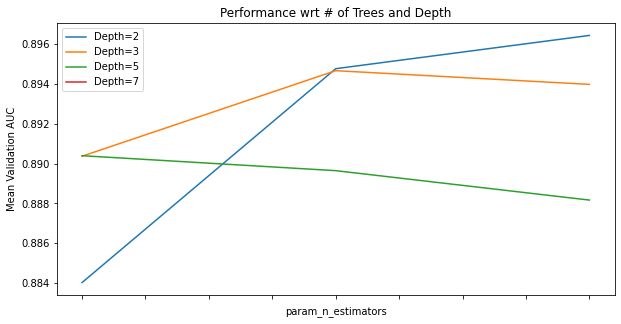

In [11]:
# First sort by number of estimators as that would be x-axis
df_cv_results.sort_values(by='param_n_estimators', inplace=True)

# Find values of AUC for learning rate of 0.05 and different values of depth
lr_d2 = df_cv_results.loc[(df_cv_results['param_learning_rate']==0.05) & (df_cv_results['param_max_depth']==2),:]
lr_d3 = df_cv_results.loc[(df_cv_results['param_learning_rate']==0.05) & (df_cv_results['param_max_depth']==3),:]
lr_d5 = df_cv_results.loc[(df_cv_results['param_learning_rate']==0.05) & (df_cv_results['param_max_depth']==5),:]
lr_d7 = df_cv_results.loc[(df_cv_results['param_learning_rate']==0.05) & (df_cv_results['param_max_depth']==7),:]

# Let us plot now
fig, ax = plt.subplots(figsize=(10,5))
lr_d2.plot(x='param_n_estimators', y='mean_test_score', label='Depth=2', ax=ax)
lr_d3.plot(x='param_n_estimators', y='mean_test_score', label='Depth=3', ax=ax)
lr_d5.plot(x='param_n_estimators', y='mean_test_score', label='Depth=5', ax=ax)
lr_d7.plot(x='param_n_estimators', y='mean_test_score', label='Depth=7', ax=ax)
plt.ylabel('Mean Validation AUC')
plt.title('Performance wrt # of Trees and Depth')

Now that we have seen the performance is higher for higher values of trees and lower depth, let us find performance w.r.t. learning rate. We fix n_estimators to 3000 and depth to 2.

Text(0.5, 1.0, 'Performance wrt learning rate')

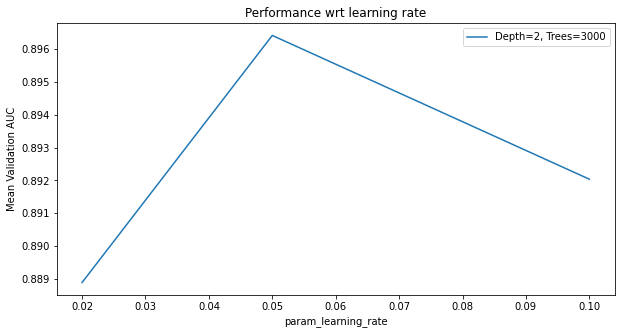

In [12]:
# First sort by learning rate as that would be x-axis
df_cv_results.sort_values(by='param_learning_rate', inplace=True)

# Find values of AUC for learning rate of 0.05 and different values of depth
lr_t3k_d2 = df_cv_results.loc[(df_cv_results['param_n_estimators']==3000) & (df_cv_results['param_max_depth']==2),:]

# Let us plot now
fig, ax = plt.subplots(figsize=(10,5))
lr_t3k_d2.plot(x='param_learning_rate', y='mean_test_score', label='Depth=2, Trees=3000', ax=ax)
plt.ylabel('Mean Validation AUC')
plt.title('Performance wrt learning rate')

## 5. Final Model
With Best Hyper Parameters from the above step

In [13]:
model_xgboost_fin = xgboost.XGBClassifier(learning_rate=0.05,
                                          max_depth=2,
                                          n_estimators=5000,
                                          subsample=0.5,
                                          colsample_bytree=0.25,
                                          eval_metric='auc',
                                          verbosity=1,
                                          use_label_encoder=False)

# Passing both training and validation dataset as we want to plot AUC for both
eval_set = [(X_train, y_train),(X_valid, y_valid)]

model_xgboost_fin.fit(X_train,
                  y_train,
                  early_stopping_rounds=20,
                  eval_set=eval_set,
                  verbose=True)

[0]	validation_0-auc:0.56167	validation_1-auc:0.55900
[1]	validation_0-auc:0.59723	validation_1-auc:0.59350
[2]	validation_0-auc:0.62081	validation_1-auc:0.62310
[3]	validation_0-auc:0.65269	validation_1-auc:0.65631
[4]	validation_0-auc:0.67349	validation_1-auc:0.67537
[5]	validation_0-auc:0.68866	validation_1-auc:0.68881
[6]	validation_0-auc:0.68792	validation_1-auc:0.68793
[7]	validation_0-auc:0.68137	validation_1-auc:0.68254
[8]	validation_0-auc:0.67961	validation_1-auc:0.68079
[9]	validation_0-auc:0.68146	validation_1-auc:0.68108
[10]	validation_0-auc:0.68861	validation_1-auc:0.68778
[11]	validation_0-auc:0.69503	validation_1-auc:0.69383
[12]	validation_0-auc:0.69756	validation_1-auc:0.69521
[13]	validation_0-auc:0.69943	validation_1-auc:0.69748
[14]	validation_0-auc:0.69800	validation_1-auc:0.69606
[15]	validation_0-auc:0.69833	validation_1-auc:0.69627
[16]	validation_0-auc:0.70447	validation_1-auc:0.70295
[17]	validation_0-auc:0.70373	validation_1-auc:0.70155
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.25, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=5000, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.5, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=1)

Let us find out the performance of the final model by calculating AUC value on training and validation sets

In [14]:
y_train_pred = model_xgboost_fin.predict_proba(X_train)[:,1]
y_valid_pred = model_xgboost_fin.predict_proba(X_valid)[:,1]

print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                    roc_auc_score(y_valid, y_valid_pred)))

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


AUC Train: 0.9233
AUC Valid: 0.8933


Let us print model performance w.r.t number of trees. The first step is to get AUC values on training and validation dataset for every value of the tree. We can use `eval_result()` function to get that. Then we can go ahead and plot it.

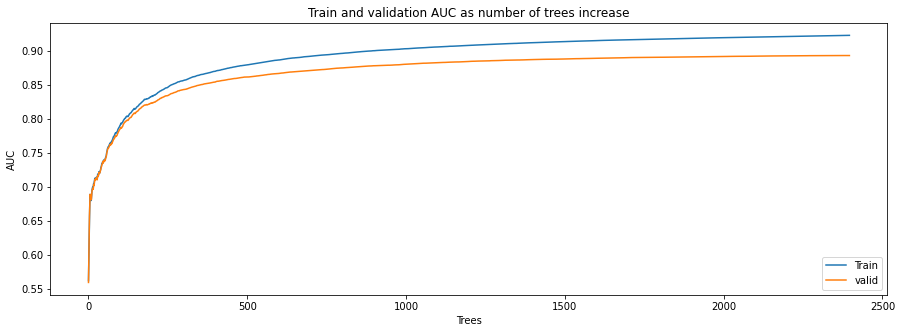

In [15]:
evaluation_results = model_xgboost_fin.evals_result()

# Index into each key to find AUC values for training and validation data after each tree
train_auc_tree = evaluation_results['validation_0']['auc']
valid_auc_tree = evaluation_results['validation_1']['auc']


# Plotting Section
plt.figure(figsize=(15,5))

plt.plot(train_auc_tree, label='Train')
plt.plot(valid_auc_tree, label='valid')

plt.title("Train and validation AUC as number of trees increase")
plt.xlabel("Trees")
plt.ylabel("AUC")
plt.legend(loc='lower right')
plt.show()

Let us also look at variable importance

In [16]:
df_var_imp = pd.DataFrame({"Variable": var_colums,
                           "Importance": model_xgboost_fin.feature_importances_}) \
                        .sort_values(by='Importance', ascending=False)
df_var_imp[:10]

,Variable,Importance
81,var_81,0.016747
139,var_139,0.013272
53,var_53,0.012411
12,var_12,0.012150
26,var_26,0.012080
110,var_110,0.011988
109,var_109,0.011525
166,var_166,0.011411
6,var_6,0.010614
80,var_80,0.010322


## 6. Score the test data
First let us import test.csv


In [17]:
df_test = pd.read_csv(input_dir + 'test.csv')
df_sample_submissions = pd.read_csv(input_dir + 'sample_submission.csv')
df_test.shape, df_sample_submissions.shape

((200000, 201), (200000, 2))

In [18]:
X_test = df_test.loc[:, var_colums]

df_sample_submissions['target'] = model_xgboost_fin.predict_proba(X_test)[:,1]
df_sample_submissions

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


,ID_code,target
0,test_0,0.085418
1,test_1,0.210438
2,test_2,0.185545
3,test_3,0.159200
4,test_4,0.041297
...,...,...
199995,test_199995,0.038197
199996,test_199996,0.007633
199997,test_199997,0.007808
199998,test_199998,0.091587


In [19]:
output_dir = '/kaggle/working/'
df_sample_submissions.to_csv(output_dir + "05_xgboost_scores.csv", index=False)